In [2]:
import tensorflow as tf
from tensorflow.keras.models import clone_model
from model_utils import simplecnn
import numpy as np

In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

In [4]:
class clint_k():
    def __init__(self, name, dataset, model, 
                optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
                ):
        self.name = name
        self.dataset = dataset  
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        self.attri = {'name':self.name, 'dataset':self.dataset, 'optimizer': self.optimizer,
                     'loss_fn' : self.loss_fn}
        
        self.model.compile(self.optimizer, loss_fn,
                          metrics=metrics)
        self.warmingUp = False
        
        
#     @tf.function
#     def set_params(self, weights): # input weight
#         self.model.set_weights(weights)
        

    def warming_up(self):
        print('Warming up process, setting slot from trainable weight')

        vp = self.model.get_weights()
        
        self.model.fit(self.dataset, verbose = 0)
        self.model.set_weights(vp)
        
        self.warmingUp = True
    def local_update(self, epochs = 1):

        if not self.warmingUp:
            self.warming_up()
            self.warmingUp = True
            print('self.warmingUp finish')
        else:
            self.optimizer.set_params(self.model)
        self.model.fit(self.dataset, epochs=epochs)
#         return 



        
    def get_config(self):
        config = self.attri
        config['model'] = self.model
        config['optimizer'] = self.optimizer
        config['loss_fn'] = self.loss_fn
        config['warmingUp'] = self.warmingUp
        return self.attri

In [5]:
# import pandas as pd
# @tf.function
# def f(x):
#     return x ** 2 

# f(0.5)
# # f(np.array(0.5))
# # f(pd.Series(0.5))

In [6]:
class PerturbedGradientDescent(tf.keras.optimizers.SGD):
    def __init__(self,
              name="PGD",
              mu=0.01,
               **kwargs):
        super().__init__(name = name, **kwargs)
#         print(name)

        self._set_hyper("prox_mu", mu)
        # Tensor versions of the constructor arguments, created in _prepare().
        self._lr_t = None
        self._mu_t = None
        self.vstar = None
        
        self._lr_t = tf.convert_to_tensor(self._hyper['learning_rate'], name="learning_rate")
        self._mu_t = tf.convert_to_tensor(self._hyper['prox_mu'], name="prox_mu")
    

    def _create_slots(self, var_list):

        for var in var_list:
            self.add_slot(var, "vt")
        for var in var_list:
            self.add_slot(var, "grad")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        lr_t = tf.cast(self._lr_t, var.dtype.base_dtype)
        mu_t = tf.cast(self._mu_t, var.dtype.base_dtype)
        
        vp = self.get_slot(var, "vt") # vt = this client's traiable variable 
        
        var_update = var.assign_sub(lr_t*(grad + mu_t*(var-vp)))
        var.assign(var_update)
#         return tf.raw_ops.ResourceApplyGradientDescent(
#           var=var_update.handle,
#           alpha=lr_t,
#           delta=grad,
#           use_locking=self._use_locking)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._initial_decay,
            "momentum": self._serialize_hyperparameter("momentum"),
            "nesterov": self.nesterov,
            "prox_mu": self.mu,
        })
        return config
    
    def set_params(self, model):
        for weights in model.trainable_variables:
            vp = self.get_slot(weights, "vt") 
            vp.assign(weights)
#             print(vp.name)
            

In [54]:
from tensorflow.keras.models import clone_model

def avg_weight(choice, Gmodel, client_list):
    tmp_model = clone_model(Gmodel) # Gmdoel  
    tmp_model.set_weights(Gmodel.get_weights()) # Gmdoel servermodel
    models = []
    weighting = []
    for _ in choice: # idx of selected client
        models.append(client_list[_].model)
        weighting.append(len(client_list[_].dataset))
        
    weights = [model.get_weights() for model in models]
    new_weights = list()
    
    weighting = np.array(weighting)/np.sum(weighting)

    weights = [i for i in weights]
    
    for i in zip(*weights):
        a = np.average(i, weights=weighting, axis=0)
        new_weights.append(a)
    
    pt = 0
    for i in range(len(tmp_model.layers)):
        a = tmp_model.layers[i]

        if len(a.get_weights()) != 0:
            a.set_weights(new_weights[pt:len(a.get_weights())+pt])
            pt+=len(a.get_weights())
    del models, weighting, new_weights
    return tmp_model


In [55]:
from utils import *

def split_client(x, y, method = bySample_bal_split, K = 6):
    
    K = K

    split_method = {}
    # split_method['method'] = lambda x,y,k : byClasses_inbal_split(x,y,k)
    split_method['method'] = bySample_bal_split


    subset= split_method['method'](x, y, K)
    view_clientDict(subset)
    return subset
    

In [56]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 標準化數據
X_train = X_train/255.0
X_test = X_test/255.0
print(X_train.shape)
print(X_train[0].shape)

idx = np.argsort(y_train)
x_train_sorted = X_train[idx]
y_train_sorted = y_train[idx]

(60000, 28, 28)
(28, 28)


In [57]:
hyper_para = dict()

hyper_para['C'] = 1

if not 'k_' in list(locals().keys()):
    hyper_para['K'] = 12
else:
    hyper_para['K'] = k_ # argparse

hyper_para['B'] = 1024 # faster?

hyper_para['mu'] = 0.01

>>> 分割給 12 個client
>>> subset client0 資料維度
-- data shape (5000, 28, 28) --label shape (5000,)
>>> subset client11 資料維度
-- data shape (5000, 28, 28) --label shape (5000,)


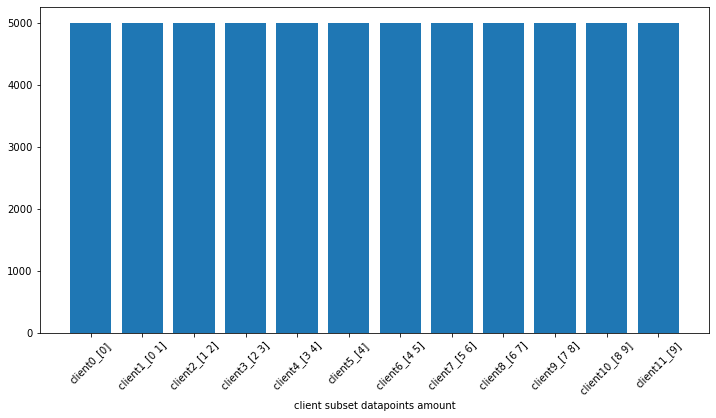

client0
Warming up process, setting slot from trainable weight
client1
Warming up process, setting slot from trainable weight
client2
Warming up process, setting slot from trainable weight
client3
Warming up process, setting slot from trainable weight
client4
Warming up process, setting slot from trainable weight
client5
Warming up process, setting slot from trainable weight
client6
Warming up process, setting slot from trainable weight
client7
Warming up process, setting slot from trainable weight
client8
Warming up process, setting slot from trainable weight
client9
Warming up process, setting slot from trainable weight
client10
Warming up process, setting slot from trainable weight
client11
Warming up process, setting slot from trainable weight


In [58]:
from tensorflow.keras.models import clone_model


Gmodel = simplecnn('server_model')
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
Gmodel.compile(PerturbedGradientDescent(), loss_fn, metrics)

# hyper_para = dict()

# if not 'k_' in list(locals().keys()):
#     hyper_para['K'] = 12
# else:
#     hyper_para['K'] = k_ # argparse

# hyper_para['B'] = 1024 # faster?
B = hyper_para['B']

hyper_para['split_method'] = str(bySample_bal_split).split(' ')[1]

subset = split_client(x_train_sorted, y_train_sorted, bySample_bal_split, hyper_para['K'])

client_list = dict() 

for _ in list(subset.keys()):
    
    train_dataset = tf.data.Dataset.from_tensor_slices((subset[_][0], subset[_][1])).cache().batch(B).prefetch(B) 
    
    tmp_model = tf.keras.models.clone_model(Gmodel)
    tmp_model.set_weights(Gmodel.get_weights())
    
    client_list[_] = clint_k(name=_, dataset=train_dataset, model=tmp_model,
               optimizer = PerturbedGradientDescent(mu=hyper_para['mu']))
#     client_list[_].model.set_weights(Gmodel.get_weights())
    
    print(client_list[_].name)
    client_list[_].warming_up()


In [59]:
# for i in list(client_list.keys())[:]: 
#     print('training client ',i)
#     k = client_list[i]
#     print(k.model.get_weights()[1])

In [60]:
def diff_model(model, Gmodel):

    weights = [model.get_weights() for model in [model, Gmodel]]
    new_weights = list()

    for weights_list_tuple in zip(*weights):
        new_weights.append(
            [np.subtract(weights_[0], weights_[1])\
                for weights_ in zip(*weights_list_tuple)])
    weight_diff = new_weights
    diff_2norm =  tf.norm([tf.norm(a) for a in weight_diff])
    print(diff_2norm)
    return diff_2norm


In [ ]:
# @tf.function
# def train_step(model, image, labels):
#     with tf.GradientTape() as tape:
#         preds = model(images)
#         loss = loss_object(labels, preds)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [61]:
import random

client_lis = list(client_list.keys())

size = int(np.ceil(hyper_para['C']*hyper_para['K']))

# print("With list:", random.sample(client_lis, size))
choice = random.sample(client_lis, size)


In [62]:
hyper_para

{'C': 1, 'K': 12, 'B': 1024, 'mu': 0.01, 'split_method': 'bySample_bal_split'}

In [102]:
# @tf.function
# def get_grad(model_, dataset_, optimizer_, loss_fn_):
    
#     optimizer = optimizer_
#     loss_fn = loss_fn_
#     model = model_
    
#     grads = []
#     for step, (x_batch_train, y_batch_train) in enumerate(dataset_):

#         # Open a GradientTape to record the operations run
#         # during the forward pass, which enables auto-differentiation.
#         with tf.GradientTape(persistent=False) as tape:


#             logits = model(x_batch_train, training=True)  # Logits for this minibatch

#             loss_value = loss_fn(y_batch_train, logits)
# #                     print(loss_value)

        
#         grad = tape.gradient(loss_value, model.trainable_weights)
#         grads.append(grad)
# #         print(step)
# #         optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     grads = [grad for grad in grads]
    
    
#     avg_grad = []
#     for i in zip(*grads):
#         a = tf.reduce_mean(i)
# #         print(np.shape(i))
# #         a = np.average(i, axis=0)
#         avg_grad.append(a)
#     return avg_grad
        
        
# optimizer = PerturbedGradientDescent(mu=hyper_para['mu'])
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
# k = client_list['client0']
# get_grad(k.model, k.dataset, optimizer, loss_fn)

InaccessibleTensorError: in user code:

    <ipython-input-102-c851650d4900>:31 get_grad  *
        a = tf.reduce_mean(i)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:2310 reduce_mean
        input_tensor, _ReductionDims(input_tensor, axis), keepdims,
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1846 _ReductionDims
        return range(0, array_ops.rank(x))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:816 rank
        return rank_internal(input, name, optimize=True)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:836 rank_internal
        input = ops.convert_to_tensor(input)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1499 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1502 _autopacking_conversion_function
        return _autopacking_helper(v, dtype, name or "packed")
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1438 _autopacking_helper
        return gen_array_ops.pack(elems_as_tensors, name=scope)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:6477 pack
        "Pack", values=values, axis=axis, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:589 _create_op_internal
        inp = self.capture(inp)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:639 capture
        % (tensor, tensor.graph, self))

    InaccessibleTensorError: The tensor 'Tensor("gradient_tape/server_model/conv2d_12/Conv2D/Conv2DBackpropFilter:0", shape=(3, 3, 1, 32), dtype=float32)' cannot be accessed here: it is defined in another function or code block. Use return values, explicit Python locals or TensorFlow collections to access it. Defined in: FuncGraph(name=tf_data_experimental_scan_scan_body, id=140435275793744); accessed from: FuncGraph(name=get_grad, id=140435276014224).
    


In [85]:
k.optimizer.get_gradients(
    loss_fn, k.model.trainable_weights
)

TypeError: Failed to convert object of type <class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'> to Tensor. Contents: <tensorflow.python.keras.losses.SparseCategoricalCrossentropy object at 0x7fb9919fe790>. Consider casting elements to a supported type.

In [65]:
import random
from tqdm.auto import tqdm, trange

def round_train(client_list, hyper_para, rounds):
    
    
    
    # select client set S_t for t-th round from all clients set S. 
    size = int(np.ceil(hyper_para['C']*len(client_list)))
    choice = random.sample(client_lis, size)
#     print(choice)
    
    # start training
    for rd in trange(rounds):
        for key in choice: 
            k = client_list[key]
            k.optimizer.set_params(k.model)
            k.model.fit(k.dataset, epochs=3, verbose=0)
        
        # aggregate model
        tmp = avg_weight(choice, Gmodel, client_list)
        Gmodel.set_weights(tmp.get_weights())

round_train(client_list, hyper_para, 50)

['client6', 'client5', 'client2', 'client0', 'client11', 'client7', 'client3', 'client4', 'client9', 'client8', 'client1', 'client10']


In [66]:
print("---\nEvaluate on Global test data on Gmodel")
results = Gmodel.evaluate(X_test[:], y_test[:], batch_size=128)
print("test loss, test acc:", results,'\n')

---
Evaluate on Global test data on Gmodel
79/79 [==============================] - 0s 2ms/step - loss: 2.2971 - sparse_categorical_accuracy: 0.1525
test loss, test acc: [2.297107696533203, 0.1525000035762787] 



In [17]:
# import time
# from tqdm.auto import tqdm, trange
# epochs = 3


# for rounds in trange(1):
    
# #     for tq in trange(len(client_list)):
#     for key in list(client_list.keys())[:]: 
# #         start = time.time()
# #         key = list(client_list.keys())[tq]
        
# #         print('training client ',key)

# #         print(k.warmingUp)

#         k = client_list[key]


#     #     k.local_update(epochs = epochs)
#         k.model.set_weights(Gmodel.get_weights())
#         # local_update over here equal to this block
#         k.optimizer.set_params(k.model)
#         k.model.fit(k.dataset, epochs=epochs, verbose=0)

#         ## diff of model
#     #     diff_model(Gmodel, k.model)
#     #     print(tf.norm([tf.norm(a) for a in diff]))

#         ## 評估global上的測試資料
# #         print("---\nEvaluate on Global test data on",i)
# #         results = k.model.evaluate(X_test[:1000], y_test[:1000], batch_size=128)
# #         print("test loss, test acc:", results,'\n')

#         ##確認 slot 有沒有被更新
#     #     print(k.optimizer.get_slot_names())
#     #     for _ in k.model.trainable_weights[1:2]:

#     #         print(k.optimizer.get_slot(_, slot_name='vt'))

# #         print('path through ', time.time()-start)

#     ## aggregate model
#     tmp = avg_weight(choice, Gmodel, client_list)
#     Gmodel.set_weights(tmp.get_weights())
    
    
# #     print("---\nEvaluate on Global test data on Gmodel")
# #     results = Gmodel.evaluate(X_test[:], y_test[:], batch_size=128)
# #     print("test loss, test acc:", results,'\n')

In [64]:
print("---\nEvaluate on Global test data on Gmodel")
results = Gmodel.evaluate(X_test[:], y_test[:], batch_size=128)
print("test loss, test acc:", results,'\n')

---
Evaluate on Global test data on Gmodel
79/79 [==============================] - 0s 2ms/step - loss: 2.3025 - sparse_categorical_accuracy: 0.0682
test loss, test acc: [2.3025102615356445, 0.0681999996304512] 

